In [1]:
#The only thing to include in the paper/presentation from this code is the bar graph

import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
#import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
statallfeatures_dic = {
    'Run Time': [],
    'Accuracy': [],   ## To store the MEAN accuracy for 5-fold CV for each model
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []   
}

In [4]:
## To store the accuracy for 5-fold CV for each model
indaccs_dic = {}

In [6]:
df2021 = pd.read_csv('SRER21_dataset_v1.csv', na_values='?').dropna()
df2017 = pd.read_csv('SRER_2017_training_bi.csv', na_values='?').dropna()
test_df = pd.concat([df2021,df2017])
train_df = pd.read_csv('SRER_2017_training_bi.csv', na_values='?').dropna()
train_df.head()
test_df.head()

,OID_,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_med,ARVI_max,EVI_mean,EVI_med,EVI_max,NDVI_mean,NDVI_med,NDVI_max,SAVI_mean,SAVI_med,SAVI_max,Veg_class
0,2,2,2,20.4,2.38,1.000000,0.273945,0.273945,0.273945,0.323257,0.323257,0.323257,0.428208,0.428208,0.428208,0.311936,0.311936,0.311936,woody
1,3,3,3,8.2,1.32,1.000000,0.530156,0.530156,0.530156,0.460513,0.460513,0.460513,0.611745,0.611745,0.611745,0.416492,0.416492,0.416492,woody
2,4,4,4,55.8,24.43,0.920000,0.477979,0.501013,0.616707,0.381095,0.384718,0.447304,0.576437,0.596638,0.673767,0.359786,0.364317,0.414173,woody
3,5,5,5,15.2,1.88,1.000000,0.342945,0.342945,0.342945,0.346714,0.346714,0.346714,0.468738,0.468738,0.468738,0.323907,0.323907,0.323907,woody
4,6,6,6,27.2,9.29,0.142857,0.044382,-0.008903,0.265536,0.181714,0.147391,0.315684,0.223522,0.178629,0.412030,0.177739,0.147325,0.299311,non-woody


In [7]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []
    
X_train = train_df.iloc[:, 5:18]
X_test = test_df.iloc[:, 5:18]
Y_train = train_df.iloc[:, -1]
Y_test = test_df.iloc[:, -1]

model.fit(X_train, Y_train)
pred_values = model.predict(X_test)

acc = accuracy_score(Y_test, pred_values)
acc_score.append(acc)

Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LogReg']=acc_score

---Run time is 0.2336896000000479 seconds ---

Accuracy of each fold: 
 [0.6820820433436533]
Avg accuracy: 0.6820820433436533
Std of accuracy : 
0.0

[[1372 2684]
 [ 602 5678]]

              precision    recall  f1-score   support

   non-woody       0.70      0.34      0.46      4056
       woody       0.68      0.90      0.78      6280

    accuracy                           0.68     10336
   macro avg       0.69      0.62      0.62     10336
weighted avg       0.69      0.68      0.65     10336

0.33826429980276135
0.904140127388535
0.6950354609929078
0.4550580431177446


In [8]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []
  
X_train = train_df.iloc[:, 5:18]
X_test = test_df.iloc[:, 5:18]
Y_train = train_df.iloc[:, -1]
Y_test = test_df.iloc[:, -1]


model.fit(X_train, Y_train)
pred_values = model.predict(X_test)
    
acc = accuracy_score(Y_test, pred_values)
acc_score.append(acc)

Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LDA']=acc_score

---Run time is 43.48916540000005 seconds ---

Accuracy of each fold: 
 [0.5236068111455109]
Avg accuracy: 0.5236068111455109
Std of accuracy : 
0.0

[[1444 2612]
 [2312 3968]]

              precision    recall  f1-score   support

   non-woody       0.38      0.36      0.37      4056
       woody       0.60      0.63      0.62      6280

    accuracy                           0.52     10336
   macro avg       0.49      0.49      0.49     10336
weighted avg       0.52      0.52      0.52     10336

0.35601577909270216
0.6318471337579618
0.3844515441959531
0.36968766001024067


In [9]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

X_train = train_df.iloc[:, 5:18]
X_test = test_df.iloc[:, 5:18]
Y_train = train_df.iloc[:, -1]
Y_test = test_df.iloc[:, -1]


model.fit(X_train, Y_train)
pred_values = model.predict(X_test)
    

acc = accuracy_score(Y_test, pred_values)
acc_score.append(acc)

Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['QDA']=acc_score

---Run time is 117.71482360000005 seconds ---

Accuracy of each fold: 
 [0.6377708978328174]
Avg accuracy: 0.6377708978328174
Std of accuracy : 
0.0

[[ 957 3099]
 [ 645 5635]]

              precision    recall  f1-score   support

   non-woody       0.60      0.24      0.34      4056
       woody       0.65      0.90      0.75      6280

    accuracy                           0.64     10336
   macro avg       0.62      0.57      0.54     10336
weighted avg       0.63      0.64      0.59     10336

0.2359467455621302
0.8972929936305732
0.5973782771535581
0.3382820784729586


In [10]:
KNN_result = []
X=train_df.iloc[:, 5:18]
Y=train_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,11):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

K=1

Accuracy of each fold: 
 [0.63018433 0.62327189 0.62442396 0.61866359 0.59976932]

Avg accuracy: 0.6192626196588693

K=2

Accuracy of each fold: 
 [0.64170507 0.61866359 0.62672811 0.60599078 0.61937716]

Avg accuracy: 0.6224929440466889

K=3

Accuracy of each fold: 
 [0.6578341  0.62442396 0.62903226 0.63709677 0.62745098]

Avg accuracy: 0.63516761543327

K=4

Accuracy of each fold: 
 [0.6624424  0.63479263 0.65092166 0.61866359 0.62745098]

Avg accuracy: 0.6388542513779705

K=5

Accuracy of each fold: 
 [0.65898618 0.62557604 0.64861751 0.6359447  0.64821223]

Avg accuracy: 0.6434673300060061

K=6

Accuracy of each fold: 
 [0.66820276 0.64170507 0.66013825 0.62327189 0.65513264]

Avg accuracy: 0.6496901227284082

K=7

Accuracy of each fold: 
 [0.67857143 0.64516129 0.64631336 0.64170507 0.65743945]

Avg accuracy: 0.6538381196881029

K=8

Accuracy of each fold: 
 [0.66935484 0.65207373 0.6624424  0.63364055 0.66320646]

Avg accuracy: 0.6561435959583075

K=9

Accuracy of each fold

In [11]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=8)

acc_score = []
Truth = []
Output = []

X_train = train_df.iloc[:, 5:18]
X_test = test_df.iloc[:, 5:18]
Y_train = train_df.iloc[:, -1]
Y_test = test_df.iloc[:, -1]

model.fit(X_train, Y_train)
pred_values = model.predict(X_test)

acc = accuracy_score(Y_test, pred_values)
acc_score.append(acc)

Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print()
print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['KNN']=acc_score


---Run time is 177.5376645 seconds ---

Accuracy of each fold: 
 [0.7118808049535603]
Avg accuracy: 0.7118808049535603
Std of accuracy : 
0.0

[[2622 1434]
 [1544 4736]]

              precision    recall  f1-score   support

   non-woody       0.63      0.65      0.64      4056
       woody       0.77      0.75      0.76      6280

    accuracy                           0.71     10336
   macro avg       0.70      0.70      0.70     10336
weighted avg       0.71      0.71      0.71     10336

0.6464497041420119
0.7541401273885351
0.6293807009121459
0.6378010216492337


In [12]:
transitionsdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statallfeatures_dic["Accuracy"],
                                statallfeatures_dic["Standard Error"],
                                statallfeatures_dic["Sensitivity"],
                                statallfeatures_dic["Specificity"],
                                statallfeatures_dic["Precision"],
                                statallfeatures_dic["F1_Score"],
                                statallfeatures_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

transitionsdf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.682082,0.0,0.338264,0.904140,0.695035,0.455058,0.233690
LDA,0.523607,0.0,0.356016,0.631847,0.384452,0.369688,43.489165
QDA,0.637771,0.0,0.235947,0.897293,0.597378,0.338282,117.714824
KNN-CV,0.711881,0.0,0.646450,0.754140,0.629381,0.637801,177.537665


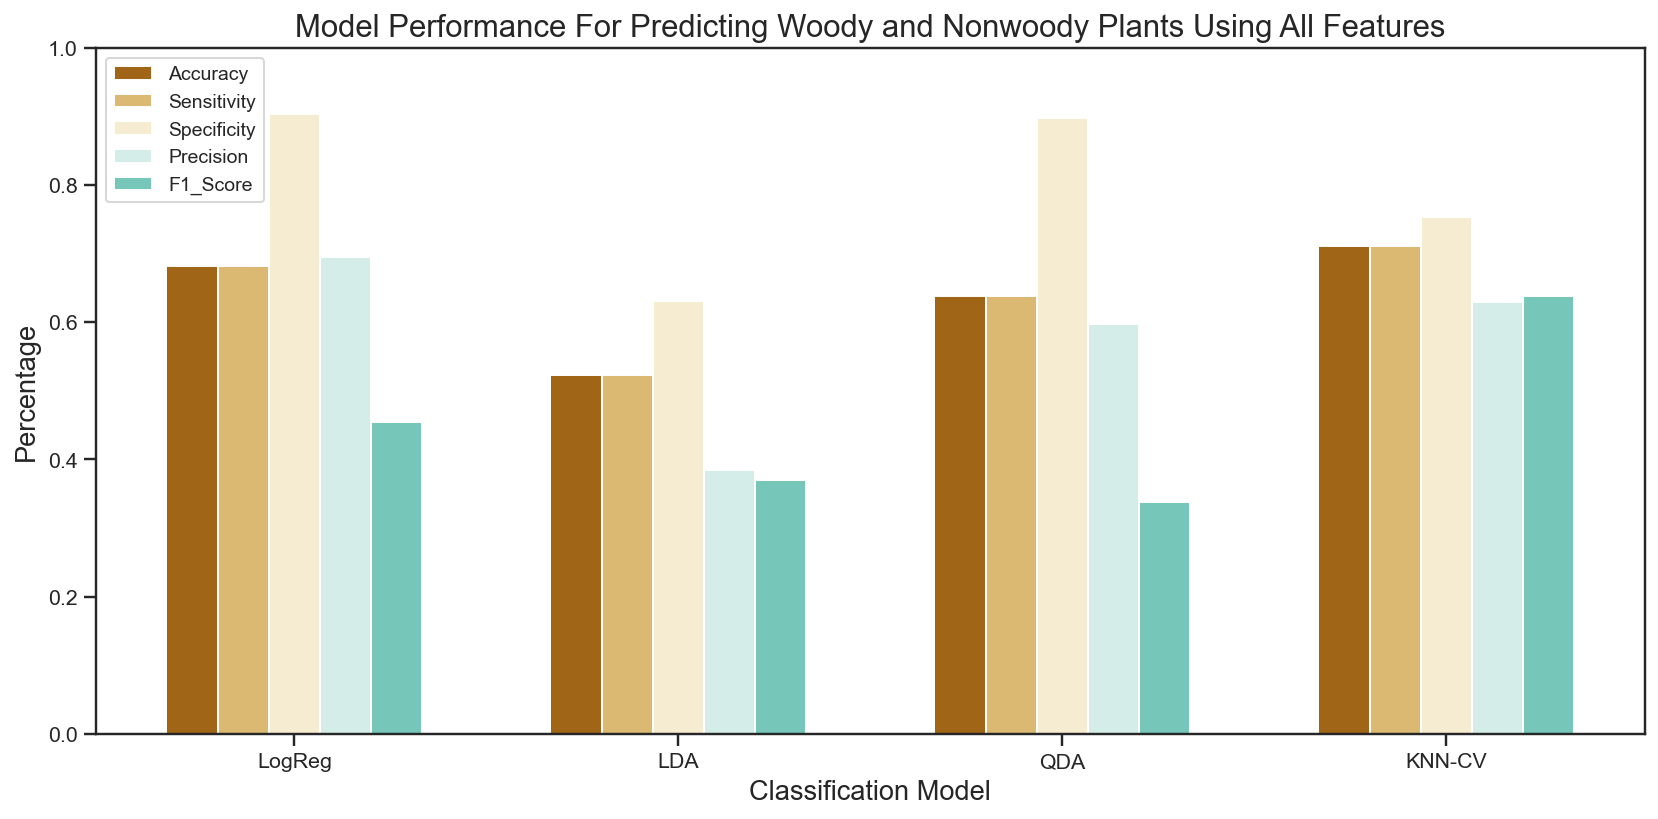

In [13]:
#Bar Graph
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
accuracies = statallfeatures_dic["Accuracy"]
sensitivities = statallfeatures_dic["Accuracy"]
specificities = statallfeatures_dic["Specificity"]
precisions = statallfeatures_dic["Precision"]
f1_scores = statallfeatures_dic["F1_Score"]

x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(12, 6))
import seaborn as sns
colors = sns.color_palette("BrBG")

acc = ax.bar(x-width*2, accuracies, width, label='Accuracy', color=colors[0])
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity', color=colors[1])
spe = ax.bar(x,specificities, width, label='Specificity', color=colors[2])
pre = ax.bar(x+width, precisions, width, label='Precision', color=colors[3])
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score', color=colors[4])

ax.set_xlabel('Classification Model', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_title('Model Performance For Predicting Woody and Nonwoody Plants Using All Features', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set(ylim=(0.0, 1))


fig.tight_layout()

plt.legend(loc="upper left", prop={'size': 10})
plt.show()

fig.savefig('AllFeaturesPerformance.png')

#Code from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py